In [ ]:
import os 

os.system('pip install sklearn')
os.system('pip install tqdm')
os.system('pip install opencv-python-headless==4.5.3.56')

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import itertools
import pandas as pd
import time
import cv2
import os
from tqdm import tqdm
import csv

In [3]:
class_names=[
    'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 
     'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
     'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 
     'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 
     'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 
     'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 
     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
     'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 
     'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 
     'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def compute_iou(box, boxes, box_area, boxes_area):

    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps(boxes1, boxes2):

    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])


    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps

In [4]:
def text_reader(folder, name):
    print("Reading the file:")
    predictionlist = []
    with open(os.path.join(folder, name), newline='') as f:
        rows = csv.reader(f)
        for row in rows:
            predictionlist.append(row)
    predictions = []
    for i in tqdm(range(len(predictionlist))):
        img_id = eval(predictionlist[i][0])
        class_id = eval(predictionlist[i][1])
        bbox = (predictionlist[i][2][1:-1]).split(' ')
        j_list = []
        for i in bbox:
            k = []
            if not i == '':
                   j_list.append(i)
        bbox = [eval(i) for i in j_list]
        predictions.append([img_id, class_id, bbox])
    return predictions

In [5]:
def get_container(liste, upto):
    last_n = 0
    container = []
    for index, row in enumerate(liste[:upto]):
        if row[0] == last_n:
            continue
        else:   
            container.append([last_n, index])
            last_n = row[0]
    return container

In [6]:
keyp=0
def load_boxes(im_id, container, datas, val=False):
    global keyp
    if val == True:
        key = keyp
    elif val == False:
        key = 0
        
    if(im_id != container[im_id - key][0]):
        print("No predictions in image:" + str(im_id))
        keyp += 1
        return [[0,0,0,0]], ['BG']
    last = container[im_id - key][1]
    assert im_id >= 0
    if im_id > 0:
        first = container[im_id - 1 - key][1]
    else:
        first = 0
    class_id_list = []
    box_list = []
    
    for data in datas[first:last]:
        class_id = data[1]
        box = data[2]
        class_id_list.append(class_id)
        box_list.append(box)
    return box_list, class_id_list

In [7]:
def evaluate(size, threshold, gt_container, pred_container, preds, gts):
    gtruths = []
    predictions = []    
    for i in tqdm(size):
        preda_bbx, pred_classes = load_boxes(i, pred_container, preds, val=True)
        gta_bbx, gt_classes = load_boxes(i, gt_container, gts)
        overlaps = compute_overlaps(np.array(preda_bbx), np.array(gta_bbx))

        match_count = 0
       # discarded_2nd_bb=[]

        try:
            for j in range(overlaps.shape[1]):
                if overlaps.shape[0] > 0:
                    if overlaps[(overlaps[:, j].argmax()), j] > threshold:
                        gtruths.append((gt_classes[j]))
                        predictions.append(pred_classes[overlaps[:, j].argmax()])
        except:
            print(overlaps.shape[0], overlaps.shape[1])
    return gtruths, predictions

In [8]:
def percentage_plot_cfmatrix(confusion_matrix, class_names, threshold, figsize = (40, 40), fontsize=8):
    confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
    df_cm = pd.DataFrame(
        (100 * confusion_matrix), index=class_names[1:], columns=class_names[1:], 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='.1f', annot_kws={"size": 10})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig("ConfusionMatrix@threshold:" + str(threshold)+".png")
    return fig

In [9]:
def elob(size, threshold, gt_container, pred_container, preds, gts, class_names):
    gtruths = []
    predictions = []
    all_gt_classes = {i:0 for i in class_names}
    class_matrix = {i:[0,0,0,0] for i in class_names}
    miss_matrix = {k:[0] for k in class_names}
    for i in tqdm(size):
        preda_bbx, pred_classes = load_boxes(i, pred_container, preds, val=True)
        gta_bbx, gt_classes = load_boxes(i, gt_container, gts)
        overlaps = compute_overlaps(np.array(preda_bbx), np.array(gta_bbx))

        match_count = 0
       # discarded_2nd_bb=[]

    
        for j in range(overlaps.shape[1]):
            all_gt_classes[class_names[gt_classes[j]]] += 1
            if overlaps.shape[0] > 0:
                if overlaps[(overlaps[:, j].argmax()),j] > threshold:
                    gtruths.append((gt_classes[j]))
                    predictions.append(pred_classes[overlaps[:, j].argmax()])
                    match_count += 1
                    ### FALSE NEGATIVE

                    # MATCHED BUT WRONG PREDICTION
                    if gt_classes[j] != pred_classes[overlaps[:, j].argmax()]:       ### 0. EŞLENİP YANLIŞ TAHMİN
                        class_matrix[class_names[gt_classes[j]]][0] += 1
                    else:
                        #TRUE POS
                        class_matrix[class_names[gt_classes[j]]][1] += 1            ### DOĞRULAR
                ##FALSE NEGATIVE
                elif overlaps[(overlaps[:, j].argmax()), j] < threshold:
                    #class_matrix[class_names[gt_classes[j]]][0] += 1
                    class_matrix[class_names[gt_classes[j]]][3] += 1                ### O GT İLE EŞLEŞEN TAHMİN YOK, MİSS
        #FALSE POS
        
        if overlaps.shape[0] > 0:
            for k in range(overlaps.shape[0]):
                if overlaps[k, overlaps[k, :].argmax()] < threshold and pred_classes[k] != 'BG':    #### PRED İLE EŞLEŞEN GT YOK, FALSE POS
                    class_matrix[class_names[pred_classes[k]]][2] += 1
    return gtruths, predictions, class_matrix, all_gt_classes

In [10]:
def get_recall(class_matrix, class_names):
    recall = [class_matrix[i][1] / (class_matrix[i][1] + class_matrix[i][0]) for i in class_names[1:]]
    return recall

def get_precision(class_matrix, class_names):
    
    precision = [class_matrix[i][1] / (class_matrix[i][1] + class_matrix[i][2]) for i in class_names[1:]]
    return precision

def get_f1_score(precision, recall):
    F1 = [(2 * (precision[k] * recall[k]) / (precision[k] + recall[k])) for k in range(len(class_names[1:]))]
    return F1

def overview(threshold):
    keyp = 0
    gt, pred, class_matrix = elob(82080, threshold, gt_container, pred_container, preds, gts, class_names)
    recall = get_recall(class_matrix, class_names)
    precision = get_precision(class_matrix, class_names)
    f1_score = get_f1_score(precision, recall)
    sn.heatmap(f1_score)
    return recall, precision, f1_score

In [11]:
train_dir = "/kfs_private/"
val_dir = "/kfs_private/"
prediction_file = "preds.txt"
gtruth_file = "gt.txt"
val_set_size = 5000 # Total image numbers to be evaluated in each step
train_total_image = 82080
iou_threshold = 0.5

In [13]:
preds = text_reader(val_dir, prediction_file)

Reading the file:


100%|██████████| 445043/445043 [00:13<00:00, 34190.07it/s]


In [14]:
gts = text_reader(val_dir, gtruth_file)

Reading the file:


100%|██████████| 291871/291871 [00:08<00:00, 34679.86it/s]


In [15]:
gt_container = get_container(gts, len(gts))

In [16]:
pred_container = get_container(preds, len(preds))

In [17]:
a1, s1 = evaluate(range(val_set_size), iou_threshold, gt_container, pred_container, preds, gts)

 69%|██████▉   | 3443/5000 [00:00<00:00, 4995.00it/s]

No predictions in image:2734


100%|██████████| 5000/5000 [00:01<00:00, 4875.05it/s]


In [18]:
cfmatrix1 = confusion_matrix(a1, s1)

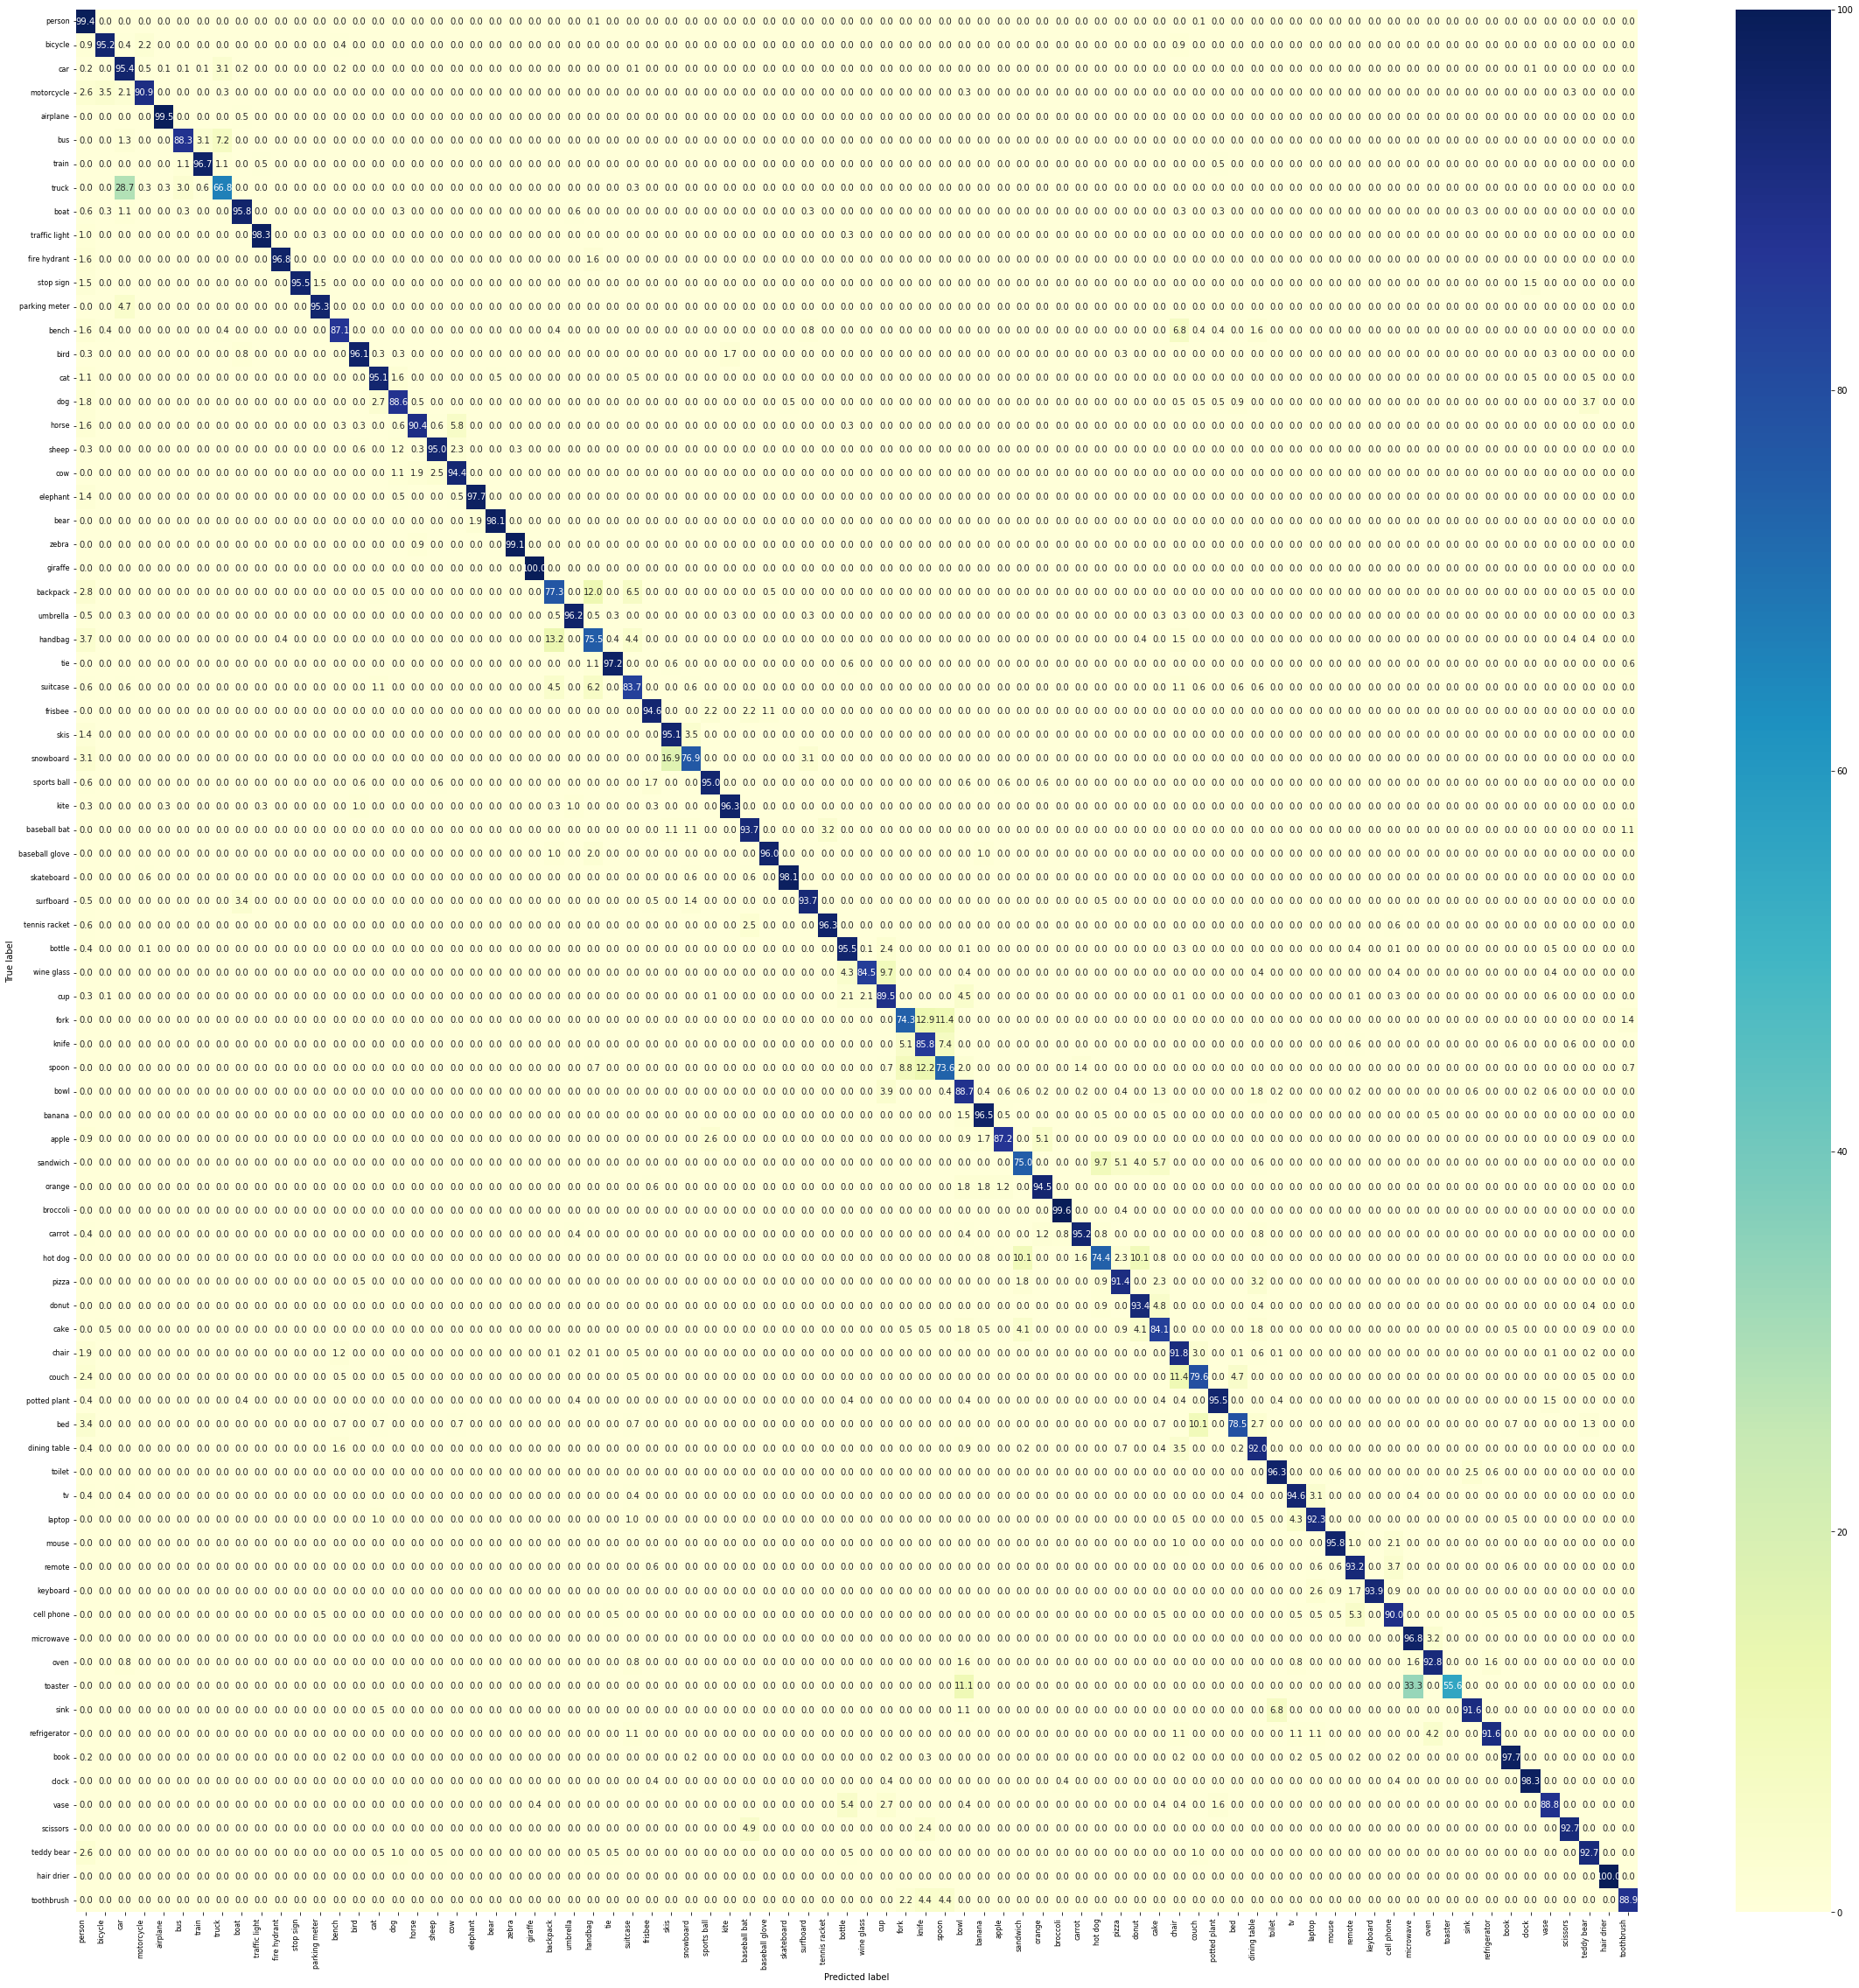

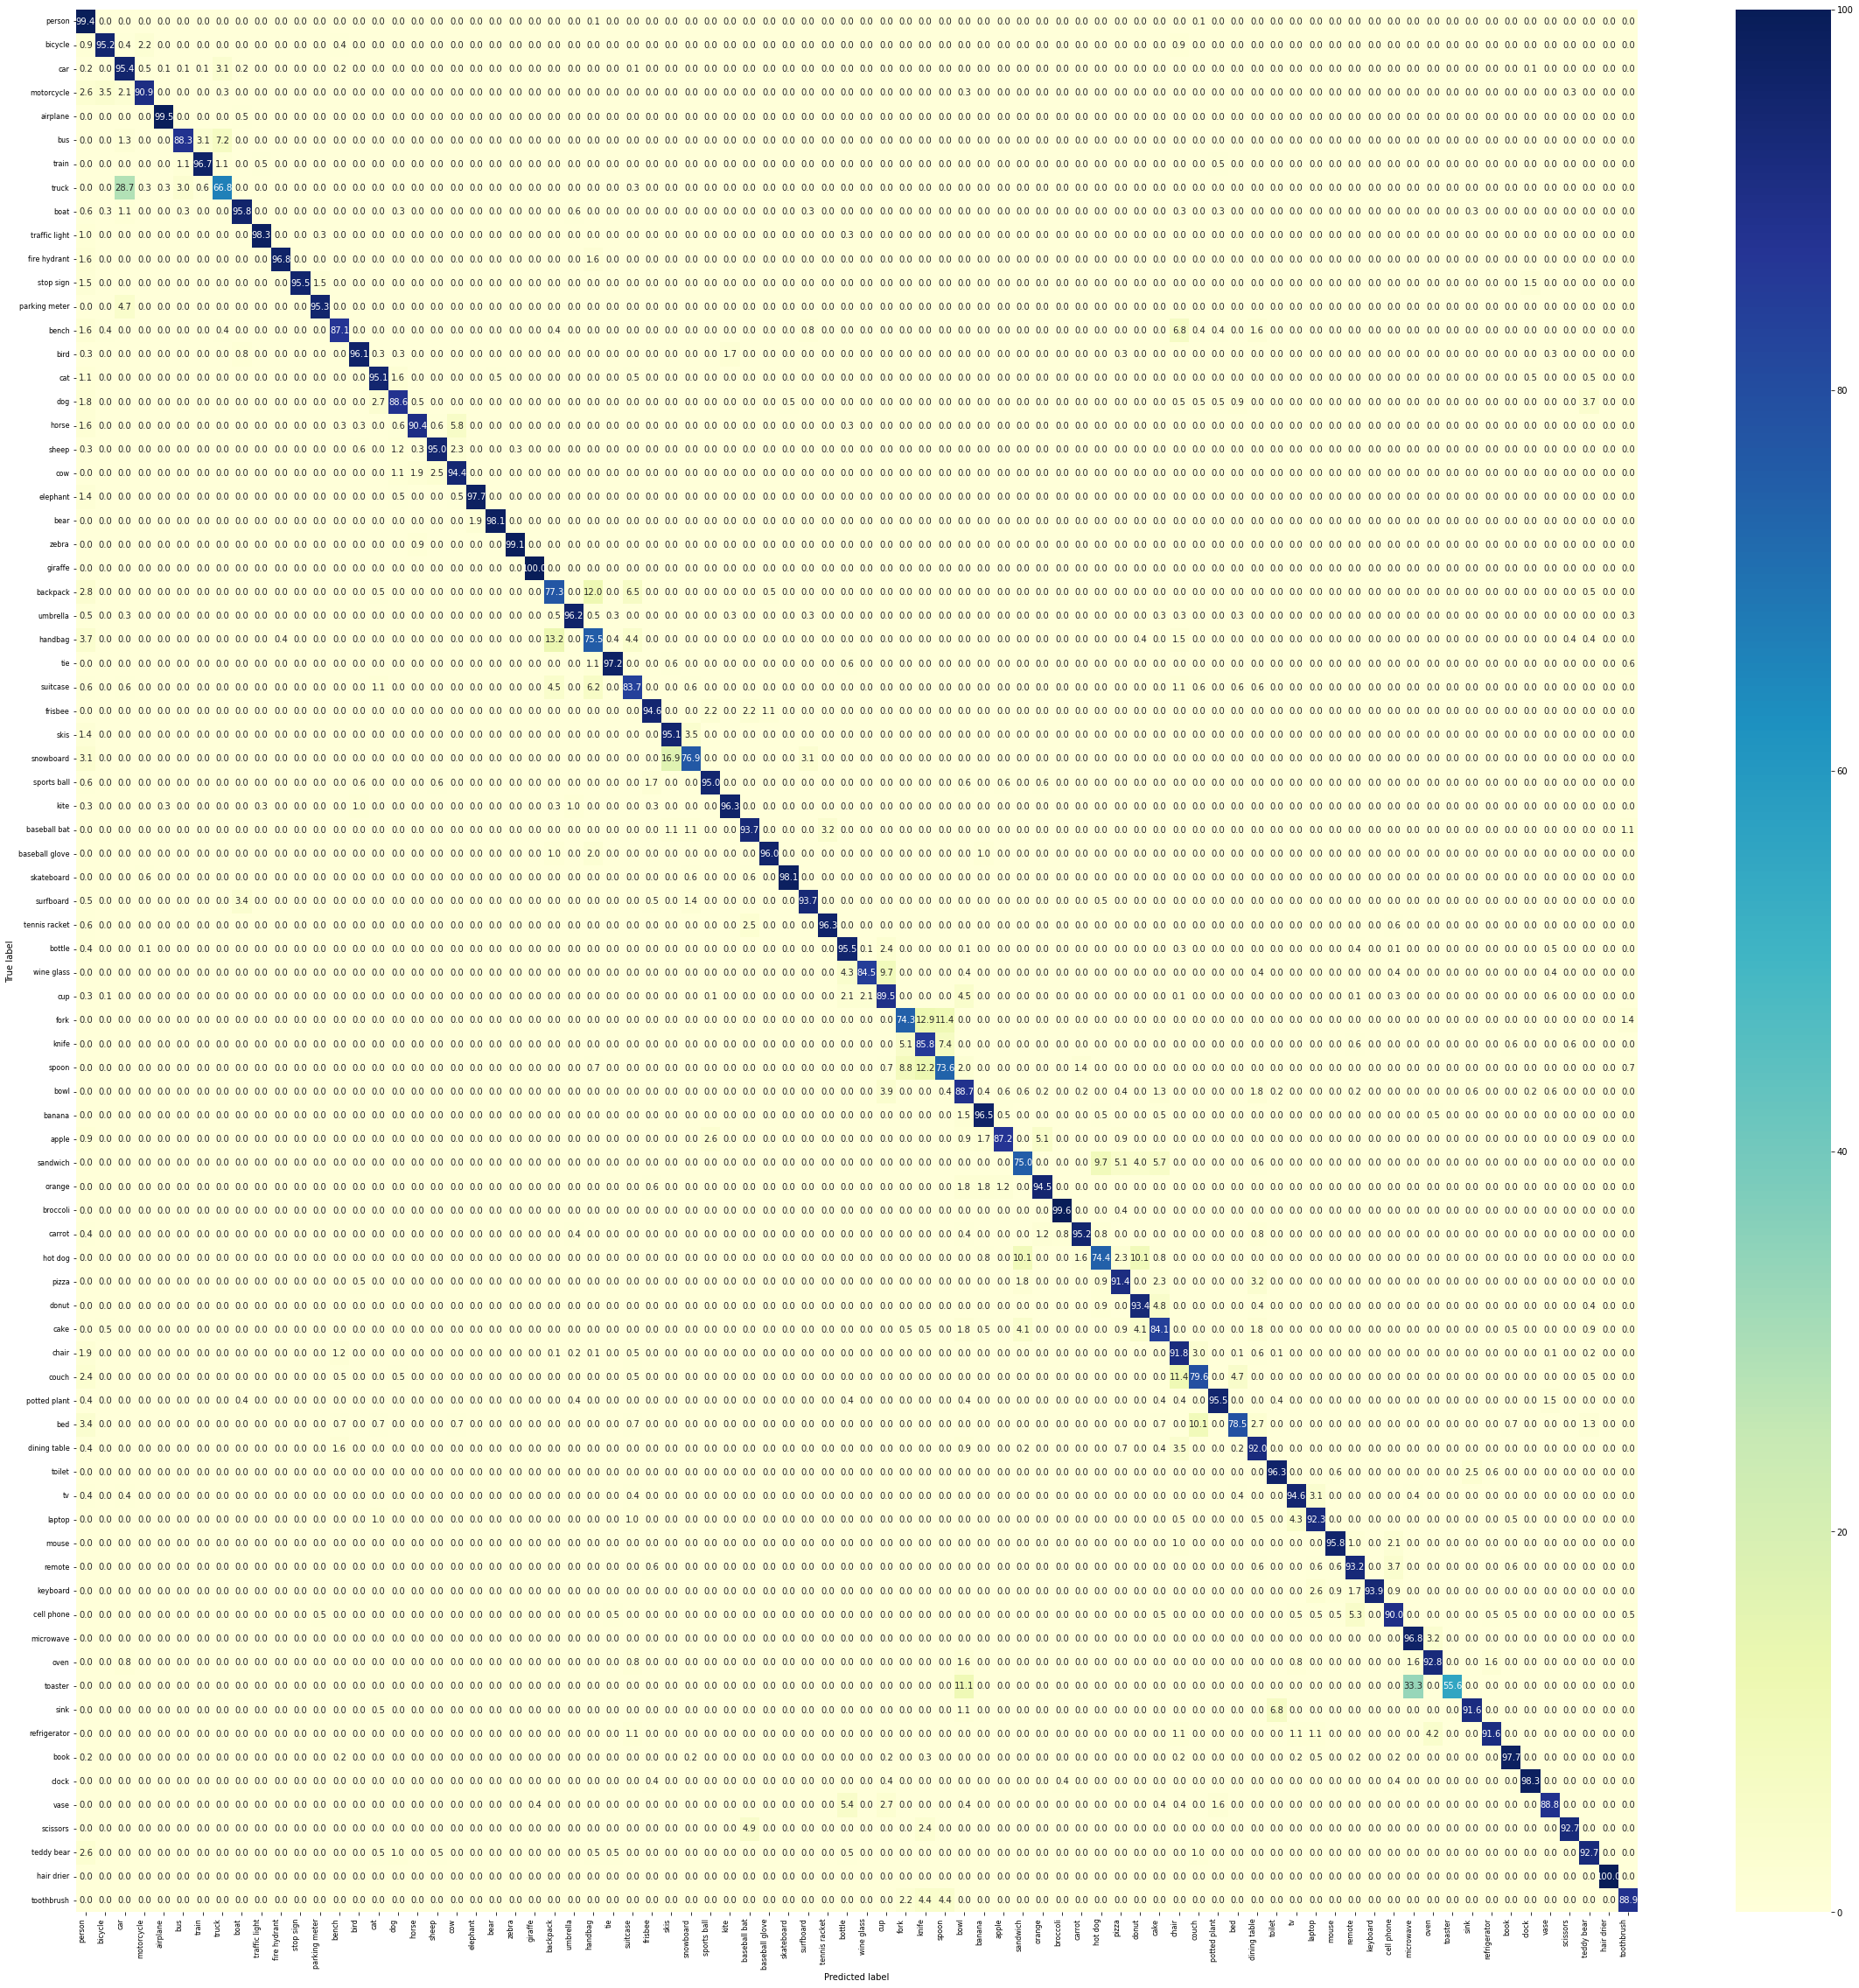

In [32]:
percentage_plot_cfmatrix(cfmatrix1, class_names, iou_threshold)

In [19]:
a2, s2 = evaluate(range(val_set_size, val_set_size * 2), iou_threshold, gt_container, pred_container, preds, gts)

100%|██████████| 5000/5000 [00:01<00:00, 4783.04it/s]


In [20]:
cfmatrix2 = confusion_matrix(a2, s2)

In [ ]:
percentage_plot_cfmatrix(cfmatrix2, class_names, iou_threshold)

In [21]:
a3, s3 = evaluate(range(val_set_size * 2, val_set_size * 3), iou_threshold, gt_container, pred_container, preds, gts)

 62%|██████▏   | 3090/5000 [00:00<00:00, 5027.49it/s]

No predictions in image:12496


100%|██████████| 5000/5000 [00:00<00:00, 5001.98it/s]


In [22]:
cfmatrix3 = confusion_matrix(a3, s3)

In [ ]:
percentage_plot_cfmatrix(cfmatrix3, class_names, iou_threshold)

In [23]:
a1, s1, class_matrix1, all_gts1 = elob(range(val_set_size), iou_threshold, gt_container, pred_container, preds, gts, class_names)

  4%|▍         | 223/5000 [00:00<00:02, 2219.27it/s]

No predictions in image:0
No predictions in image:1
No predictions in image:2
No predictions in image:3
No predictions in image:4
No predictions in image:5
No predictions in image:6
No predictions in image:7
No predictions in image:8
No predictions in image:9
No predictions in image:10
No predictions in image:11
No predictions in image:12
No predictions in image:13
No predictions in image:14
No predictions in image:15
No predictions in image:16
No predictions in image:17
No predictions in image:18
No predictions in image:19
No predictions in image:20
No predictions in image:21
No predictions in image:22
No predictions in image:23
No predictions in image:24
No predictions in image:25
No predictions in image:26
No predictions in image:27
No predictions in image:28
No predictions in image:29
No predictions in image:30
No predictions in image:31
No predictions in image:32
No predictions in image:33
No predictions in image:34
No predictions in image:35
No predictions in image:36
No predicti

 14%|█▍        | 700/5000 [00:00<00:01, 2324.81it/s]

No predictions in image:432
No predictions in image:433
No predictions in image:434
No predictions in image:435
No predictions in image:436
No predictions in image:437
No predictions in image:438
No predictions in image:439
No predictions in image:440
No predictions in image:441
No predictions in image:442
No predictions in image:443
No predictions in image:444
No predictions in image:445
No predictions in image:446
No predictions in image:447
No predictions in image:448
No predictions in image:449
No predictions in image:450
No predictions in image:451
No predictions in image:452
No predictions in image:453
No predictions in image:454
No predictions in image:455
No predictions in image:456
No predictions in image:457
No predictions in image:458
No predictions in image:459
No predictions in image:460
No predictions in image:461
No predictions in image:462
No predictions in image:463
No predictions in image:464
No predictions in image:465
No predictions in image:466
No predictions in im

 23%|██▎       | 1172/5000 [00:00<00:01, 2327.46it/s]

No predictions in image:917
No predictions in image:918
No predictions in image:919
No predictions in image:920
No predictions in image:921
No predictions in image:922
No predictions in image:923
No predictions in image:924
No predictions in image:925
No predictions in image:926
No predictions in image:927
No predictions in image:928
No predictions in image:929
No predictions in image:930
No predictions in image:931
No predictions in image:932
No predictions in image:933
No predictions in image:934
No predictions in image:935
No predictions in image:936
No predictions in image:937
No predictions in image:938
No predictions in image:939
No predictions in image:940
No predictions in image:941
No predictions in image:942
No predictions in image:943
No predictions in image:944
No predictions in image:945
No predictions in image:946
No predictions in image:947
No predictions in image:948
No predictions in image:949
No predictions in image:950
No predictions in image:951
No predictions in im

 33%|███▎      | 1657/5000 [00:00<00:01, 2312.38it/s]

No predictions in image:1406
No predictions in image:1407
No predictions in image:1408
No predictions in image:1409
No predictions in image:1410
No predictions in image:1411
No predictions in image:1412
No predictions in image:1413
No predictions in image:1414
No predictions in image:1415
No predictions in image:1416
No predictions in image:1417
No predictions in image:1418
No predictions in image:1419
No predictions in image:1420
No predictions in image:1421
No predictions in image:1422
No predictions in image:1423
No predictions in image:1424
No predictions in image:1425
No predictions in image:1426
No predictions in image:1427
No predictions in image:1428
No predictions in image:1429
No predictions in image:1430
No predictions in image:1431
No predictions in image:1432
No predictions in image:1433
No predictions in image:1434
No predictions in image:1435
No predictions in image:1436
No predictions in image:1437
No predictions in image:1438
No predictions in image:1439
No predictions

 43%|████▎     | 2158/5000 [00:00<00:01, 2382.24it/s]

No predictions in image:1875
No predictions in image:1876
No predictions in image:1877
No predictions in image:1878
No predictions in image:1879
No predictions in image:1880
No predictions in image:1881
No predictions in image:1882
No predictions in image:1883
No predictions in image:1884
No predictions in image:1885
No predictions in image:1886
No predictions in image:1887
No predictions in image:1888
No predictions in image:1889
No predictions in image:1890
No predictions in image:1891
No predictions in image:1892
No predictions in image:1893
No predictions in image:1894
No predictions in image:1895
No predictions in image:1896
No predictions in image:1897
No predictions in image:1898
No predictions in image:1899
No predictions in image:1900
No predictions in image:1901
No predictions in image:1902
No predictions in image:1903
No predictions in image:1904
No predictions in image:1905
No predictions in image:1906
No predictions in image:1907
No predictions in image:1908
No predictions

 53%|█████▎    | 2633/5000 [00:01<00:01, 2337.68it/s]

No predictions in image:2336
No predictions in image:2337
No predictions in image:2338
No predictions in image:2339
No predictions in image:2340
No predictions in image:2341
No predictions in image:2342
No predictions in image:2343
No predictions in image:2344
No predictions in image:2345
No predictions in image:2346
No predictions in image:2347
No predictions in image:2348
No predictions in image:2349
No predictions in image:2350
No predictions in image:2351
No predictions in image:2352
No predictions in image:2353
No predictions in image:2354
No predictions in image:2355
No predictions in image:2356
No predictions in image:2357
No predictions in image:2358
No predictions in image:2359
No predictions in image:2360
No predictions in image:2361
No predictions in image:2362
No predictions in image:2363
No predictions in image:2364
No predictions in image:2365
No predictions in image:2366
No predictions in image:2367
No predictions in image:2368
No predictions in image:2369
No predictions

 62%|██████▏   | 3124/5000 [00:01<00:00, 2391.68it/s]


No predictions in image:2812
No predictions in image:2813
No predictions in image:2814
No predictions in image:2815
No predictions in image:2816
No predictions in image:2817
No predictions in image:2818
No predictions in image:2819
No predictions in image:2820
No predictions in image:2821
No predictions in image:2822
No predictions in image:2823
No predictions in image:2824
No predictions in image:2825
No predictions in image:2826
No predictions in image:2827
No predictions in image:2828
No predictions in image:2829
No predictions in image:2830
No predictions in image:2831
No predictions in image:2832
No predictions in image:2833
No predictions in image:2834
No predictions in image:2835
No predictions in image:2836
No predictions in image:2837
No predictions in image:2838
No predictions in image:2839
No predictions in image:2840
No predictions in image:2841
No predictions in image:2842
No predictions in image:2843
No predictions in image:2844
No predictions in image:2845
No prediction

 72%|███████▏  | 3621/5000 [00:01<00:00, 2288.78it/s]

No predictions in image:3288
No predictions in image:3289
No predictions in image:3290
No predictions in image:3291
No predictions in image:3292
No predictions in image:3293
No predictions in image:3294
No predictions in image:3295
No predictions in image:3296
No predictions in image:3297
No predictions in image:3298
No predictions in image:3299
No predictions in image:3300
No predictions in image:3301
No predictions in image:3302
No predictions in image:3303
No predictions in image:3304
No predictions in image:3305
No predictions in image:3306
No predictions in image:3307
No predictions in image:3308
No predictions in image:3309
No predictions in image:3310
No predictions in image:3311
No predictions in image:3312
No predictions in image:3313
No predictions in image:3314
No predictions in image:3315
No predictions in image:3316
No predictions in image:3317
No predictions in image:3318
No predictions in image:3319
No predictions in image:3320
No predictions in image:3321
No predictions

 82%|████████▏ | 4108/5000 [00:01<00:00, 2357.39it/s]

No predictions in image:3784
No predictions in image:3785
No predictions in image:3786
No predictions in image:3787
No predictions in image:3788
No predictions in image:3789
No predictions in image:3790
No predictions in image:3791
No predictions in image:3792
No predictions in image:3793
No predictions in image:3794
No predictions in image:3795
No predictions in image:3796
No predictions in image:3797
No predictions in image:3798
No predictions in image:3799
No predictions in image:3800
No predictions in image:3801
No predictions in image:3802
No predictions in image:3803
No predictions in image:3804
No predictions in image:3805
No predictions in image:3806
No predictions in image:3807
No predictions in image:3808
No predictions in image:3809
No predictions in image:3810
No predictions in image:3811
No predictions in image:3812
No predictions in image:3813
No predictions in image:3814
No predictions in image:3815
No predictions in image:3816
No predictions in image:3817
No predictions

 92%|█████████▏| 4579/5000 [00:01<00:00, 2277.62it/s]

No predictions in image:4251
No predictions in image:4252
No predictions in image:4253
No predictions in image:4254
No predictions in image:4255
No predictions in image:4256
No predictions in image:4257
No predictions in image:4258
No predictions in image:4259
No predictions in image:4260
No predictions in image:4261
No predictions in image:4262
No predictions in image:4263
No predictions in image:4264
No predictions in image:4265
No predictions in image:4266
No predictions in image:4267
No predictions in image:4268
No predictions in image:4269
No predictions in image:4270
No predictions in image:4271
No predictions in image:4272
No predictions in image:4273
No predictions in image:4274
No predictions in image:4275
No predictions in image:4276
No predictions in image:4277
No predictions in image:4278
No predictions in image:4279
No predictions in image:4280
No predictions in image:4281
No predictions in image:4282
No predictions in image:4283
No predictions in image:4284
No predictions

100%|██████████| 5000/5000 [00:02<00:00, 2304.75it/s]

No predictions in image:4678
No predictions in image:4679
No predictions in image:4680
No predictions in image:4681
No predictions in image:4682
No predictions in image:4683
No predictions in image:4684
No predictions in image:4685
No predictions in image:4686
No predictions in image:4687
No predictions in image:4688
No predictions in image:4689
No predictions in image:4690
No predictions in image:4691
No predictions in image:4692
No predictions in image:4693
No predictions in image:4694
No predictions in image:4695
No predictions in image:4696
No predictions in image:4697
No predictions in image:4698
No predictions in image:4699
No predictions in image:4700
No predictions in image:4701
No predictions in image:4702
No predictions in image:4703
No predictions in image:4704
No predictions in image:4705
No predictions in image:4706
No predictions in image:4707
No predictions in image:4708
No predictions in image:4709
No predictions in image:4710
No predictions in image:4711
No predictions

In [24]:
pframe1 = pd.DataFrame.from_dict(class_matrix1)

In [25]:
real1 = pframe1.reindex((pframe1.iloc[0] + pframe1.iloc[1] + pframe1.iloc[3]).sort_values().index, axis=1)

In [26]:
number_of_instances1 = (pframe1.iloc[[0, 1, 2, 3]].sum())

In [27]:
percentage1 = pframe1/(pframe1.iloc[[0, 1, 2, 3]].sum())

In [ ]:
plt.figure(figsize=(45, 10))

heatmap = sn.heatmap(percentage1, annot=True, annot_kws={"rotation":90}, cmap="YlGnBu", fmt='.1f')
heatmap.yaxis.set_ticklabels(["FN", "TP", "FP", "MISS"], rotation=90, ha='right', fontsize=20);

In [ ]:
plt.figure(figsize=(45, 10))

heatmap = sn.heatmap(real1, annot=True, cmap="YlGnBu", fmt='d', annot_kws={'size':8}, linewidths=.5)
heatmap.yaxis.set_ticklabels(["FN", "TP", "FP", "MISS"], rotation=90, ha='right', fontsize=20);

In [ ]:
plt.figure(figsize=(20, 5))

plt.plot((real1.iloc[3] / (real1.iloc[1])))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical');
plt.title("Miss Rate for Validation Set-1")
plt.ylabel("Miss rate");

In [ ]:
plt.figure(figsize=(20, 5))

plt.plot(real1.mean())
plt.title("No. of Instances in Validation Set-1")
plt.ylabel("Instance Number")
plt.xticks([i for i in range(80)], (class_names[1:]), rotation='vertical');

In [28]:
complete_list1 = [[], [], []]
for i_threshold in range(4, 8, 1):
    i_threshold = i_threshold / 10
    keyp = 0
    a, s, class_matrix1, gt_classes = elob(range(val_set_size), i_threshold, gt_container, pred_container, preds, gts, class_names) ### Train_total_image'ı değiştir.
    recall1 = get_recall(class_matrix1, class_names)
    precision1 = get_precision(class_matrix1, class_names)
    f1_score1 = get_f1_score(precision1, recall1)
    complete_list1[0].append(recall1)
    complete_list1[1].append(precision1)
    complete_list1[2].append(f1_score1)

 70%|██████▉   | 3485/5000 [00:00<00:00, 4336.67it/s]

No predictions in image:2734


 71%|███████   | 3548/5000 [00:00<00:00, 4403.84it/s]

No predictions in image:2734


 70%|███████   | 3501/5000 [00:00<00:00, 3914.88it/s]

No predictions in image:2734


 70%|███████   | 3519/5000 [00:00<00:00, 4116.82it/s]

No predictions in image:2734


100%|██████████| 5000/5000 [00:01<00:00, 3873.83it/s]


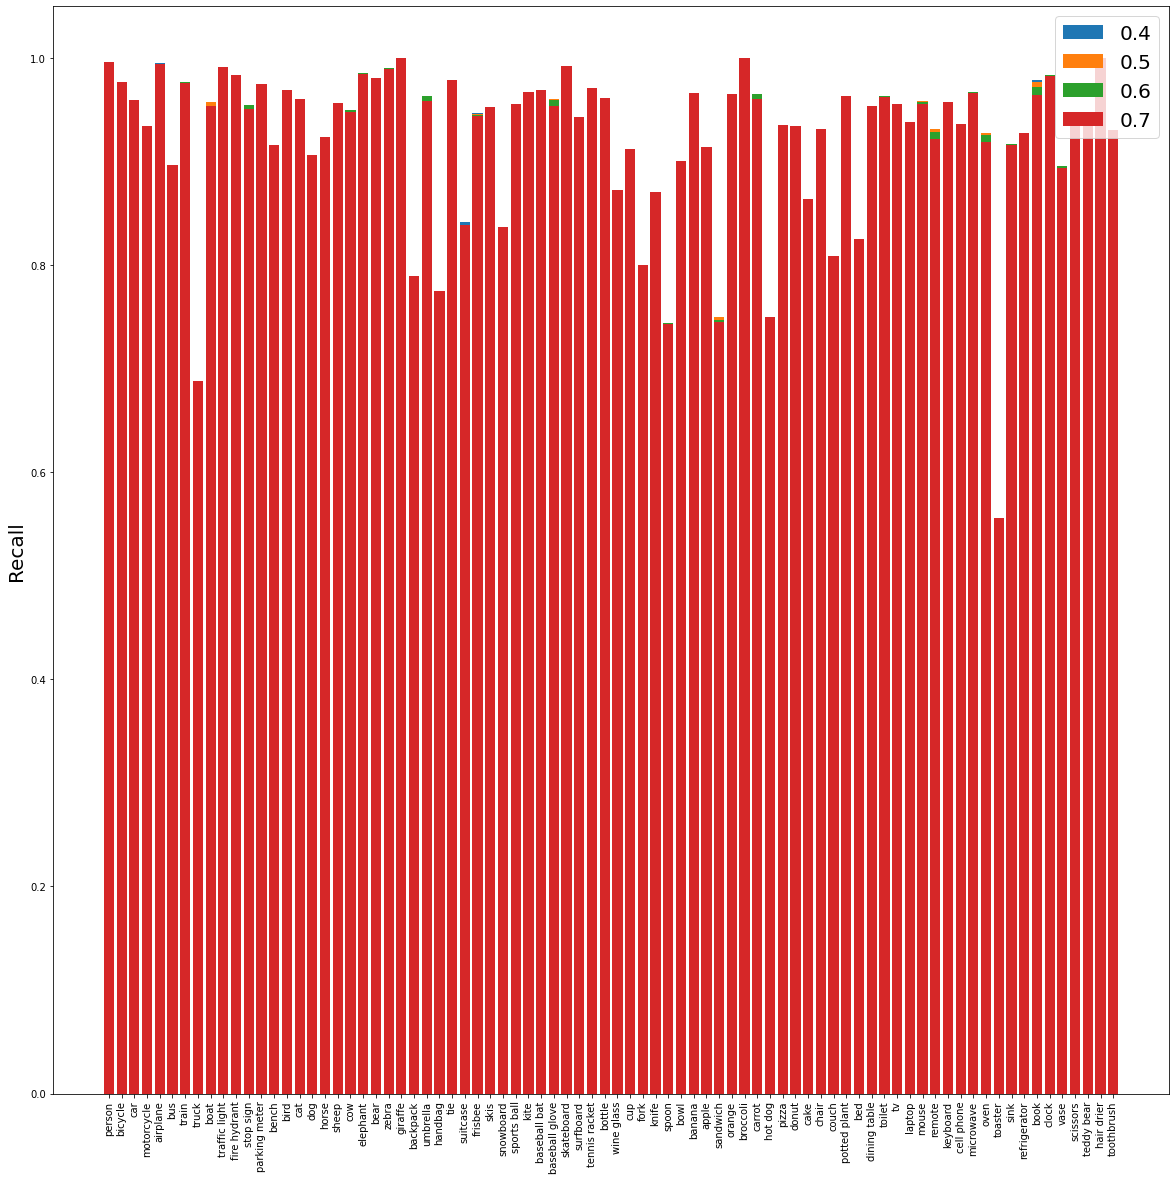

In [48]:
plt.figure(figsize=(20, 20))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list1[0])):
    plt.bar(class_names[1:], complete_list1[0][i])

plt.title("Recall Rate for Validation Set-1 with Different IOU Threshholds")
plt.ylabel("Recall", fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20);

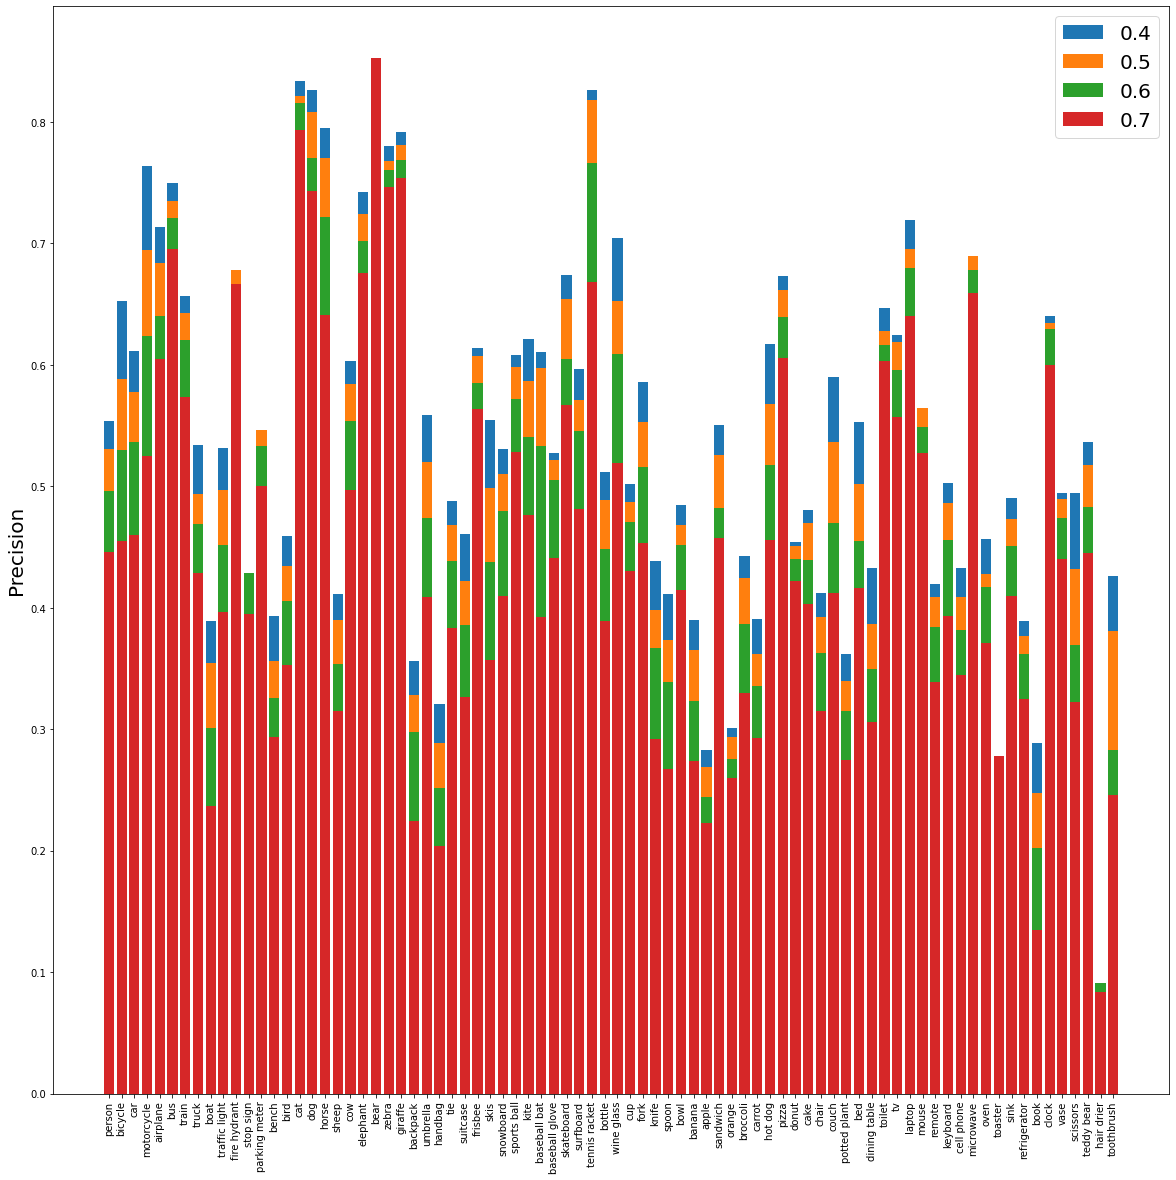

In [49]:
plt.figure(figsize=(20, 20))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list1[1])):
    plt.bar(class_names[1:], complete_list1[1][i])
    
plt.title("Precision for Validation Set-1 with Different IOU Threshholds")
plt.ylabel("Precision", fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20)
plt.savefig("0.4-0.7 Precision.png")

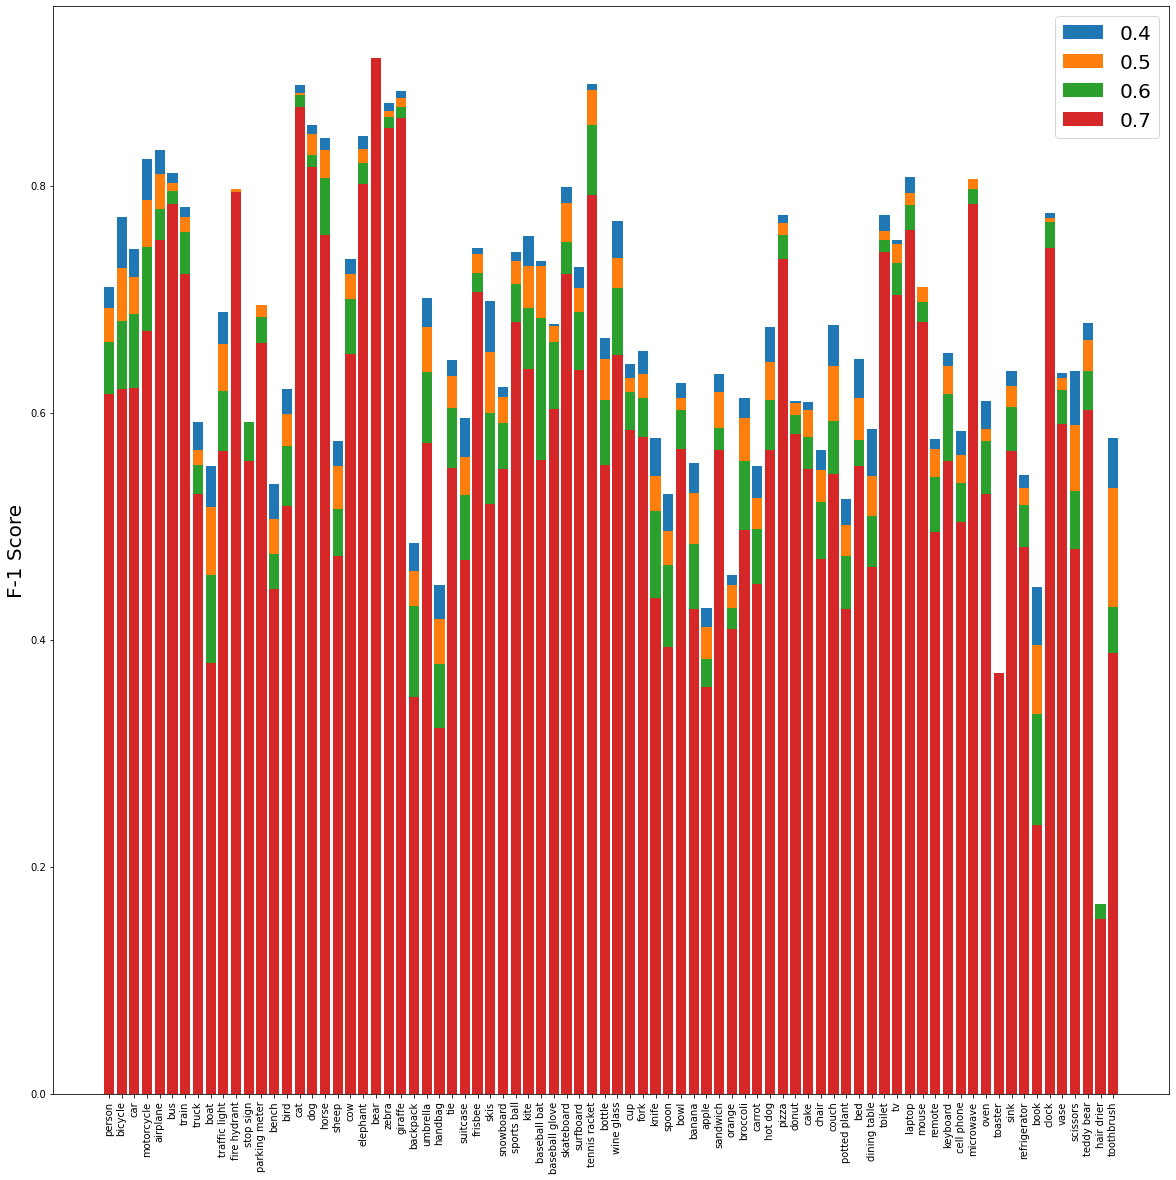

In [50]:
plt.figure(figsize=(20, 20))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list1[2])):
    plt.bar(class_names[1:], complete_list1[2][i])

plt.title("F-1 Score for Validation Set-1 with Different IOU Threshholds")
plt.ylabel("F-1 Score", fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20);

In [29]:
a2, s2, class_matrix2, all_gts2 = elob(range(val_set_size, val_set_size * 2), iou_threshold, gt_container, pred_container, preds, gts, class_names)

100%|██████████| 5000/5000 [00:01<00:00, 3429.70it/s]


In [30]:
pframe2 = pd.DataFrame.from_dict(class_matrix2)

In [31]:
real2 = pframe2.reindex((pframe2.iloc[0] + pframe2.iloc[1] + pframe2.iloc[3]).sort_values().index, axis=1)

In [32]:
percentage2 = pframe2/(pframe2.iloc[[0, 1, 2, 3]].sum())

In [33]:
number_of_instances2 = (pframe2.iloc[[0, 1, 2, 3]].sum())

In [ ]:
plt.figure(figsize=(45, 10))

heatmap = sn.heatmap(percentage2, annot=True, annot_kws={"rotation":90}, cmap="YlGnBu", fmt='.1f')
heatmap.yaxis.set_ticklabels(["FN", "TP", "FP", "MISS"], rotation=90, ha='right', fontsize=20);

In [ ]:
plt.figure(figsize=(45, 10))

heatmap = sn.heatmap(real2, annot=True, cmap="YlGnBu", fmt='d', annot_kws={'size':8}, linewidths=.5)
heatmap.yaxis.set_ticklabels(["FN", "TP", "FP", "MISS"], rotation=90, ha='right', fontsize=20);

In [ ]:
plt.figure(figsize=(20, 5))

plt.plot((real2.iloc[3] / (real2.iloc[1])))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
plt.title("Miss Rate for Validation Set-2")
plt.ylabel("Miss rate");

In [ ]:
plt.figure(figsize=(20, 5))

plt.plot(real2.mean())
plt.title("No. of Instances in Validation Set-2")
plt.ylabel("Instance Number")
plt.xticks([i for i in range(80)], (class_names[1:]), rotation='vertical');

In [34]:
complete_list2 = [[], [], []]
val_total_image = range(1000, 2000)
for i_threshold in range(4, 8, 1):
    i_threshold = i_threshold / 10
    keyp = 0
    a, s, class_matrix2, gt_classes = elob(range(val_set_size, val_set_size * 2), i_threshold, gt_container, pred_container, preds, gts, class_names) ### Train_total_image'ı değiştir.
    recall2 = get_recall(class_matrix2, class_names)
    precision2 = get_precision(class_matrix2, class_names)
    f1_score2 = get_f1_score(precision2, recall2)
    complete_list2[0].append(recall2)
    complete_list2[1].append(precision2)
    complete_list2[2].append(f1_score2)

  9%|▉         | 441/5000 [00:00<00:01, 4408.94it/s]

No predictions in image:5000


  9%|▊         | 433/5000 [00:00<00:01, 4323.92it/s]

No predictions in image:5000


 17%|█▋        | 860/5000 [00:00<00:00, 4310.44it/s]

No predictions in image:5000


 18%|█▊        | 876/5000 [00:00<00:00, 4360.79it/s]

No predictions in image:5000


100%|██████████| 5000/5000 [00:01<00:00, 4381.86it/s]


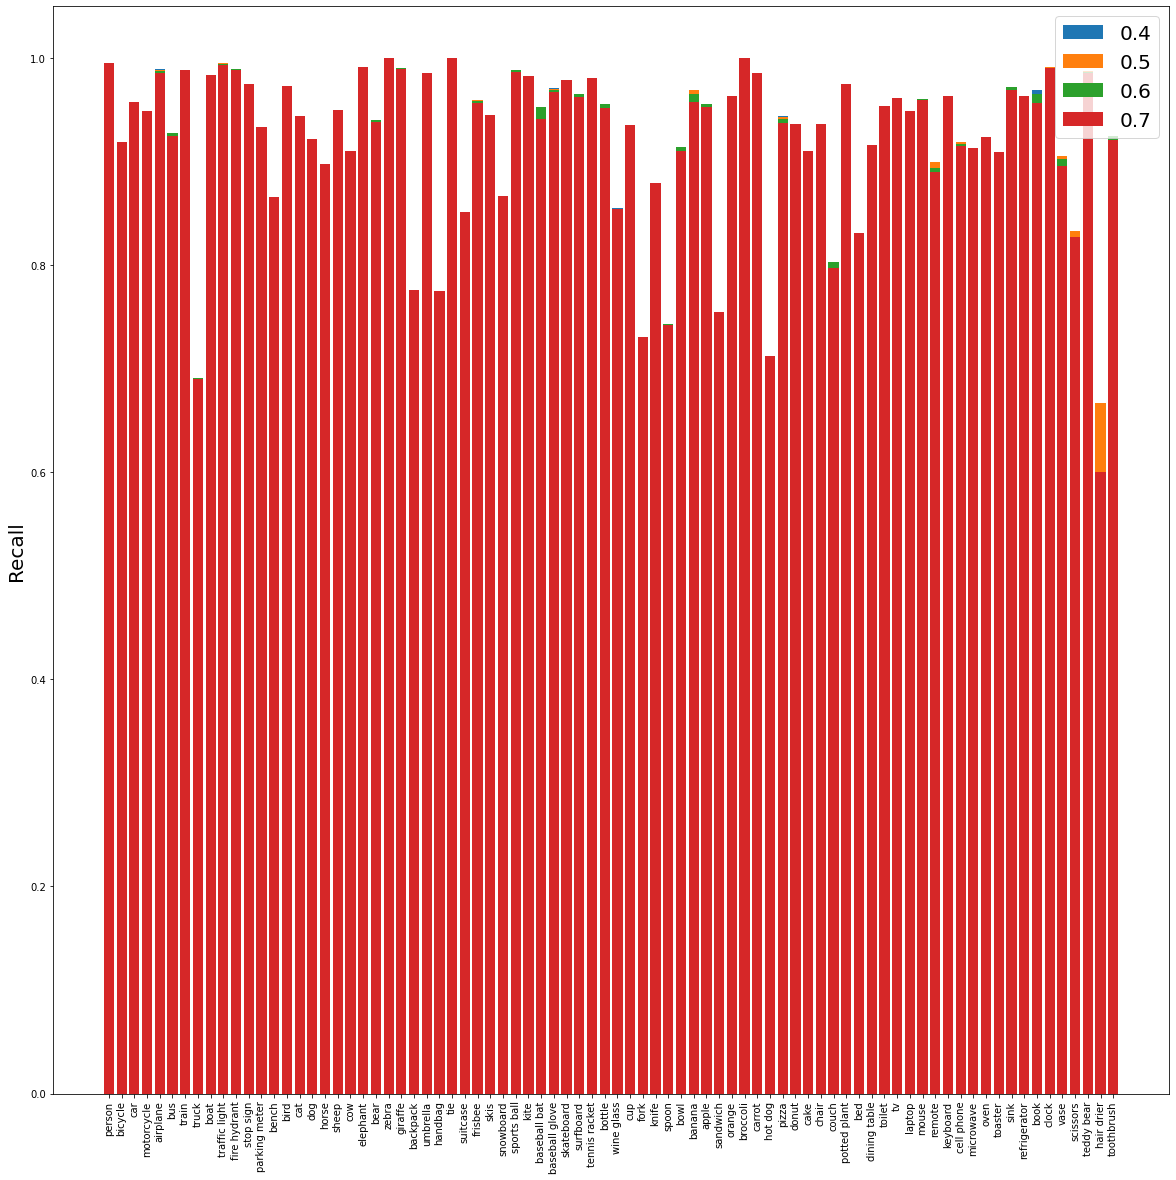

In [57]:
plt.figure(figsize=(20, 20))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list2[0])):
    plt.bar(class_names[1:], complete_list2[0][i])
    
plt.title("Recall Rate for Validation Set-2 with Different IOU Threshholds")
plt.ylabel("Recall", fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20)

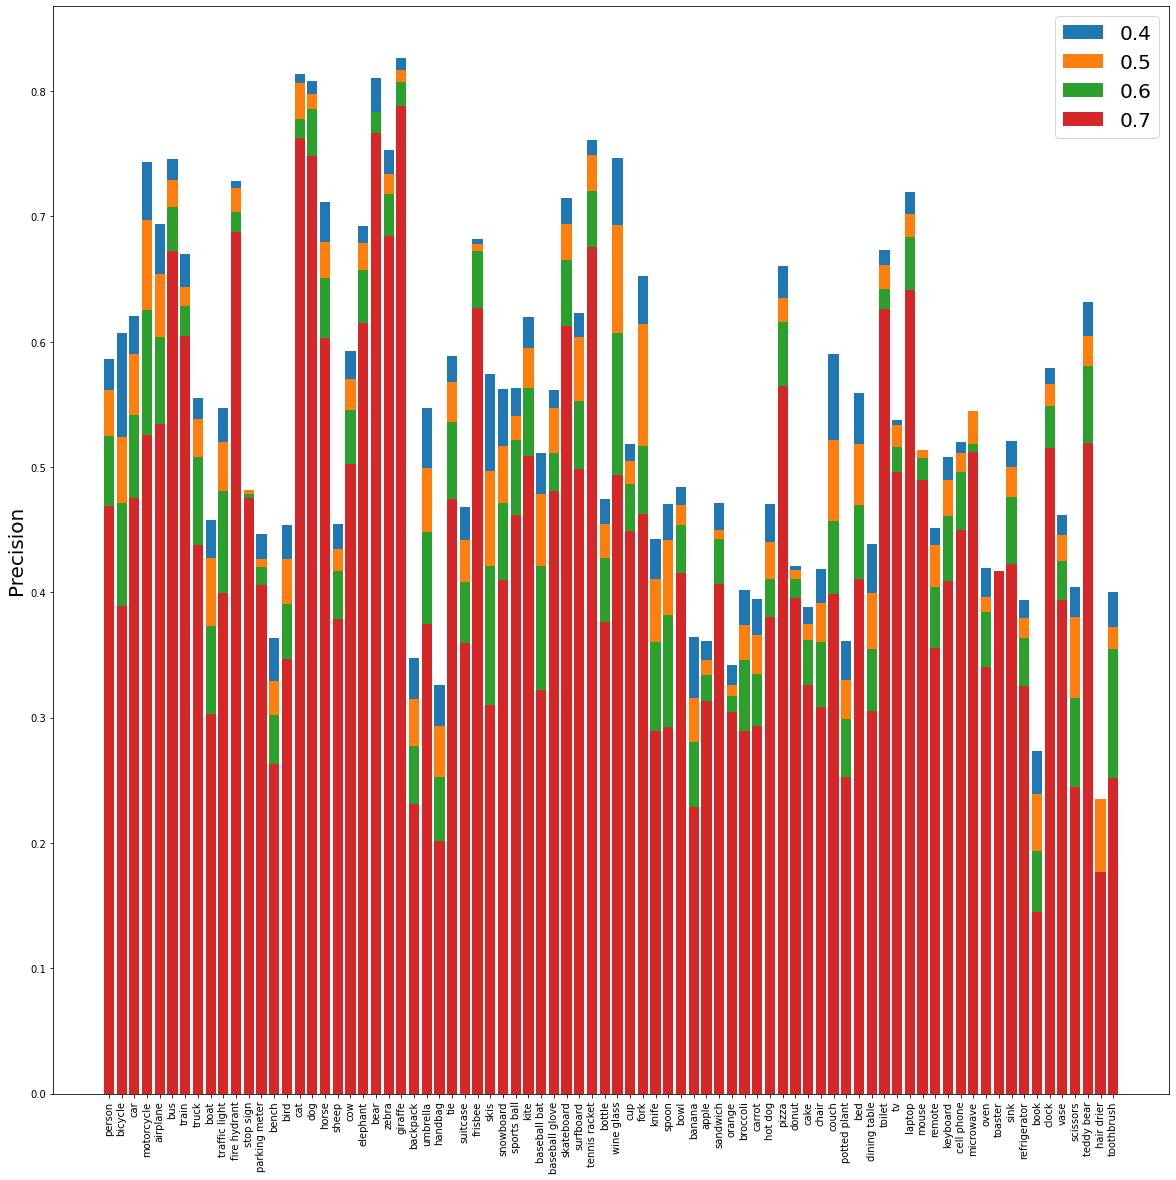

In [58]:
plt.figure(figsize=(20, 20))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list2[1])):
    plt.bar(class_names[1:], complete_list2[1][i])
    
plt.title("Precision for Validation Set-2 with Different IOU Threshholds")
plt.ylabel("Precision",fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20);

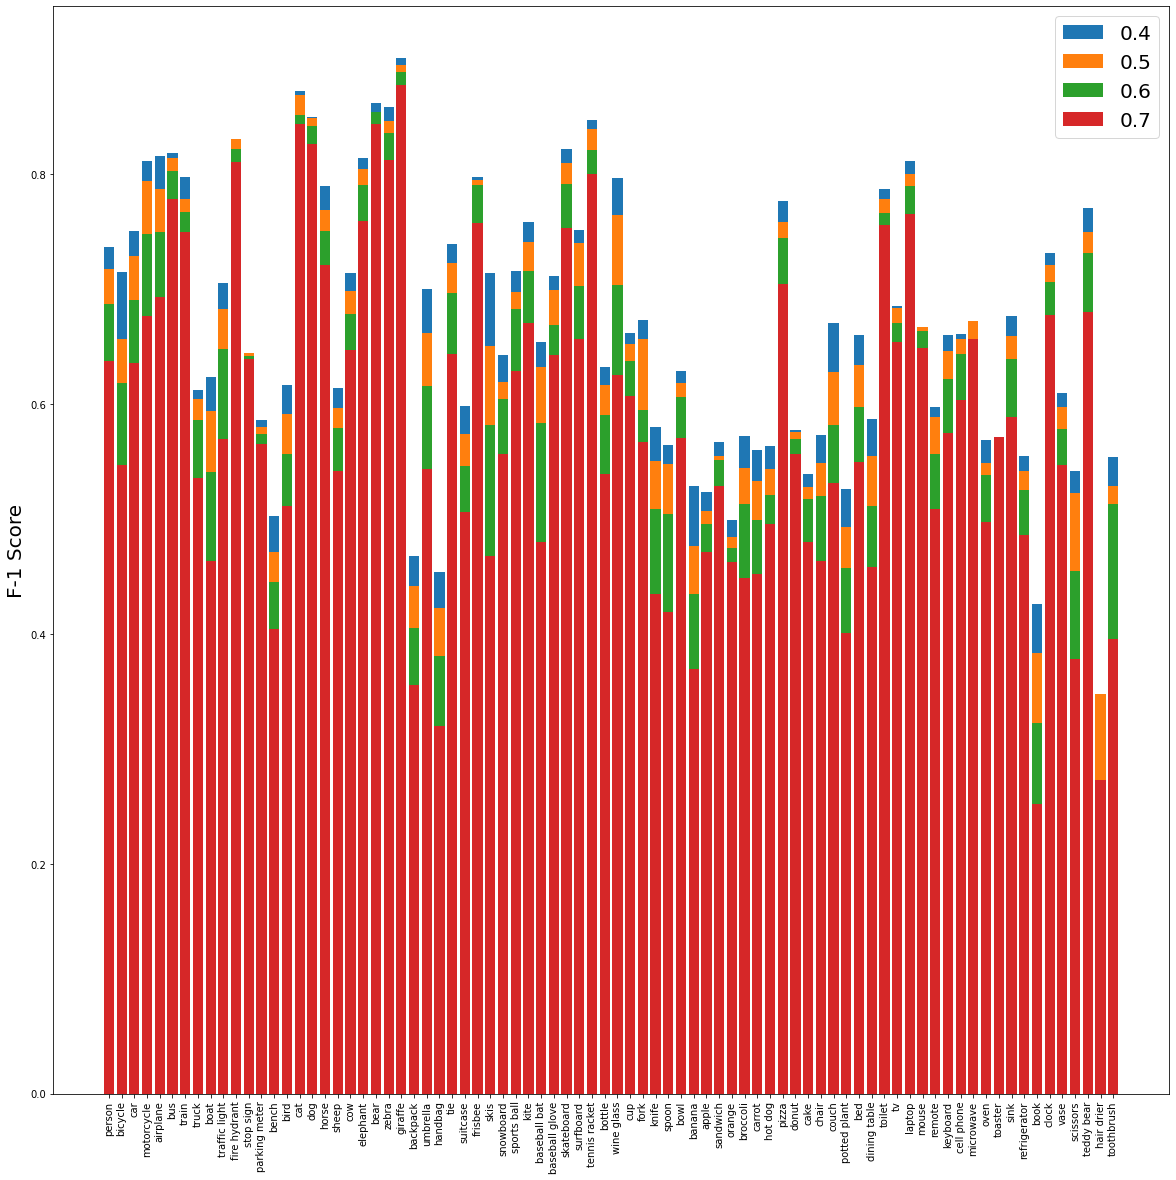

In [59]:
plt.figure(figsize=(20, 20))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list2[2])):
    plt.bar(class_names[1:], complete_list2[2][i])
    
plt.title("F-1 Score for Validation Set-1 with Different IOU Threshholds")
plt.ylabel("F-1 Score", fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20);

In [35]:
a3, s3, class_matrix3, all_gts3 = elob(range(val_set_size * 2, val_set_size * 3), iou_threshold, gt_container, pred_container, preds, gts, class_names)

 66%|██████▌   | 3304/5000 [00:00<00:00, 4444.69it/s]

No predictions in image:12496


100%|██████████| 5000/5000 [00:01<00:00, 4443.16it/s]


In [36]:
pframe3 = pd.DataFrame.from_dict(class_matrix3)

### Order classes by their instance number:

In [37]:
real3 = pframe3.reindex((pframe3.iloc[0] + pframe3.iloc[1] + pframe3.iloc[3]).sort_values().index, axis=1)

In [38]:
number_of_instances3 = (pframe3.iloc[[0, 1, 2, 3]].sum())

In [39]:
percentage3 = pframe3/(pframe3.iloc[[0, 1, 2, 3]].sum())

In [9]:
plt.figure(figsize=(45, 10))

heatmap = sn.heatmap(percentage3, annot=True, annot_kws={"rotation":90}, cmap="YlGnBu", fmt='.1f')
heatmap.yaxis.set_ticklabels(["FN", "TP", "FP", "MISS"], rotation=90, ha='right', fontsize=20);

NameError: name 'plt' is not defined

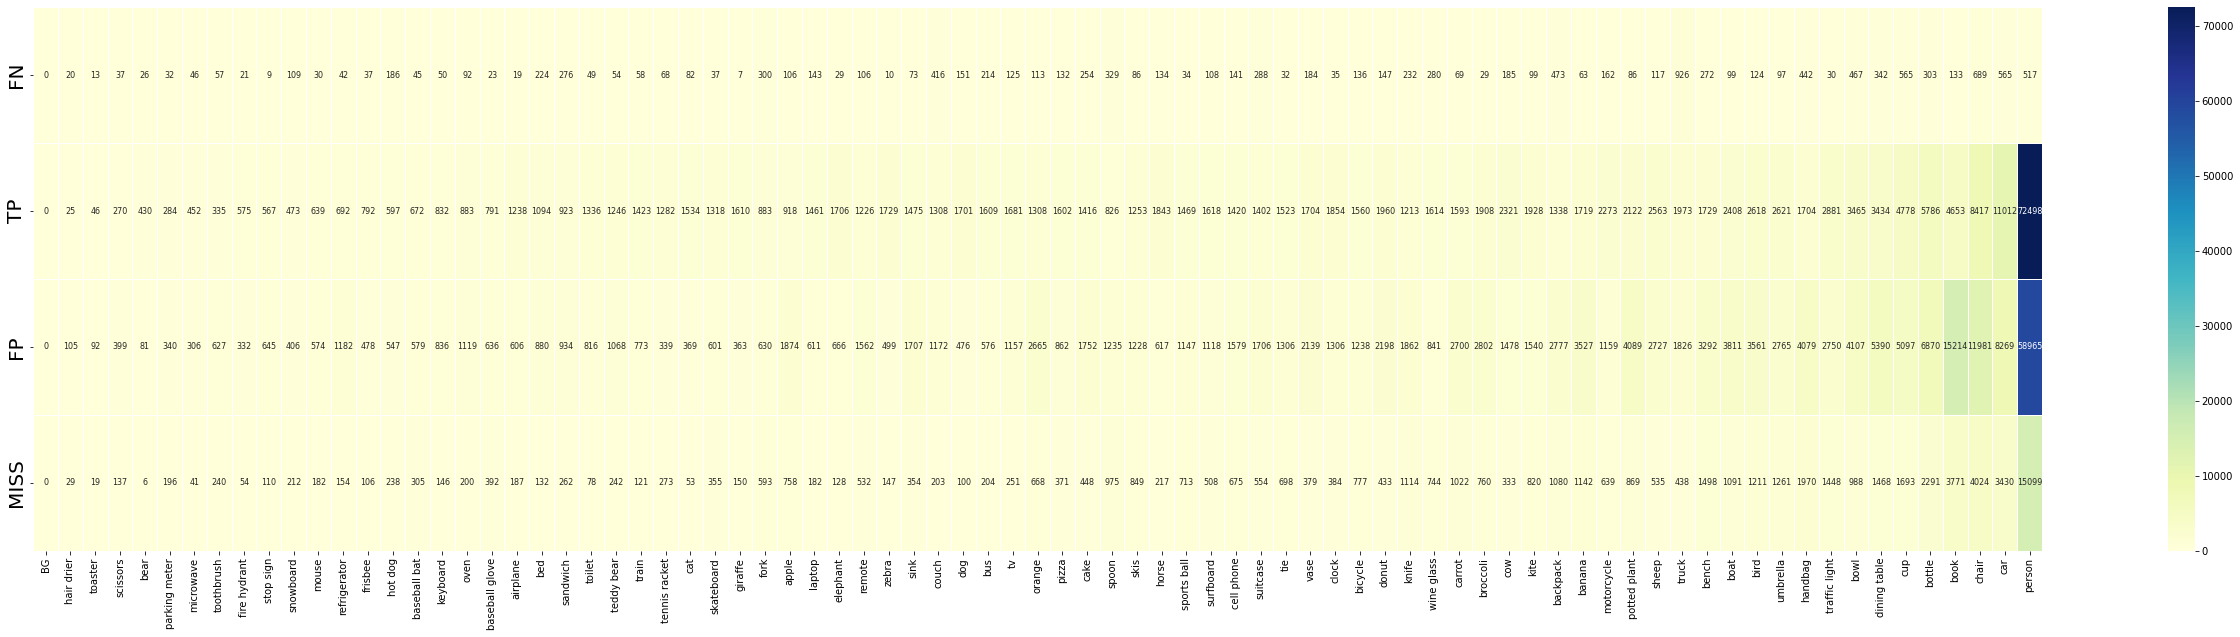

In [50]:
plt.figure(figsize=(45, 10))

heatmap = sn.heatmap(real3, annot=True, cmap="YlGnBu", fmt='d', annot_kws={'size':8}, linewidths=.5)
heatmap.yaxis.set_ticklabels(["FN", "TP", "FP", "MISS"], rotation=90, ha='right', fontsize=20);

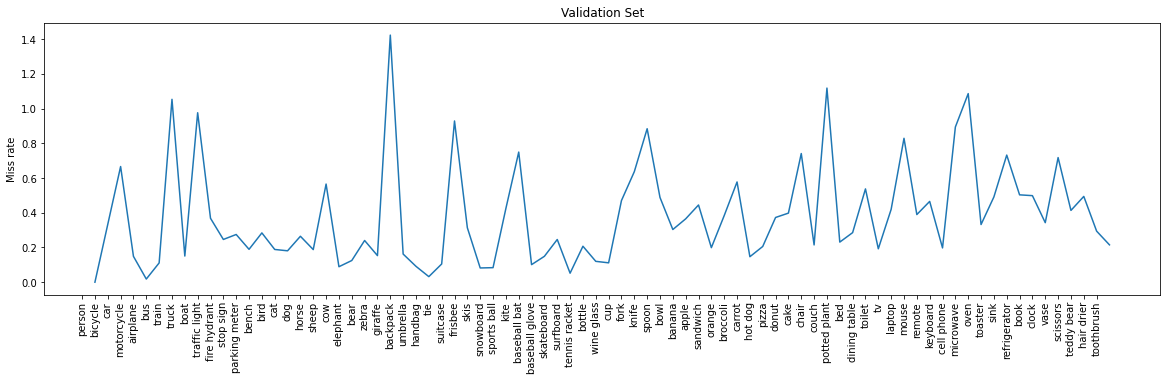

In [70]:
plt.figure(figsize=(20, 5))

plt.plot((real3.iloc[3] / (real3.iloc[1])))
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
plt.title("Miss Rate for Validation Set-3")
plt.ylabel("Miss rate");

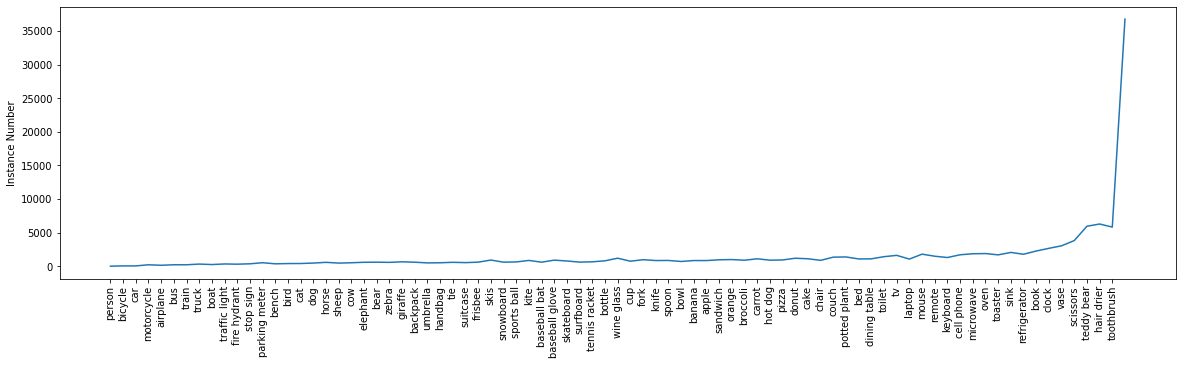

In [52]:
plt.figure(figsize=(20, 5))

plt.plot(real3.mean())
plt.title("No. of Instances in Validation Set-3")
plt.ylabel("Instance Number")
plt.xticks([i for i in range(80)], (class_names[1:]), rotation='vertical');

In [40]:
complete_list3 = [[], [], []]
val_total_image = range(1000, 2000)
for i_threshold in range(4, 8, 1):
    i_threshold = i_threshold / 10
    keyp = 0
    a, s, class_matrix3, gt_classes = elob(range(val_set_size * 2, val_set_size * 3), i_threshold, gt_container, pred_container, preds, gts, class_names) ### Train_total_image'ı değiştir.
    recall3 = get_recall(class_matrix3, class_names)
    precision3 = get_precision(class_matrix3, class_names)
    f1_score3 = get_f1_score(precision3, recall3)
    complete_list3[0].append(recall3)
    complete_list3[1].append(precision3)
    complete_list3[2].append(f1_score3)

  9%|▉         | 443/5000 [00:00<00:01, 4423.14it/s]

No predictions in image:10000


 65%|██████▍   | 3234/5000 [00:00<00:00, 4440.39it/s]

No predictions in image:12496


 19%|█▊        | 929/5000 [00:00<00:00, 4669.49it/s]

No predictions in image:10000


 65%|██████▌   | 3251/5000 [00:00<00:00, 4450.84it/s]

No predictions in image:12496


 19%|█▊        | 927/5000 [00:00<00:00, 4656.30it/s]

No predictions in image:10000


 65%|██████▍   | 3233/5000 [00:00<00:00, 4422.59it/s]

No predictions in image:12496


  9%|▉         | 442/5000 [00:00<00:01, 4415.53it/s]

No predictions in image:10000


 65%|██████▌   | 3262/5000 [00:00<00:00, 4517.95it/s]

No predictions in image:12496


100%|██████████| 5000/5000 [00:01<00:00, 4422.23it/s]


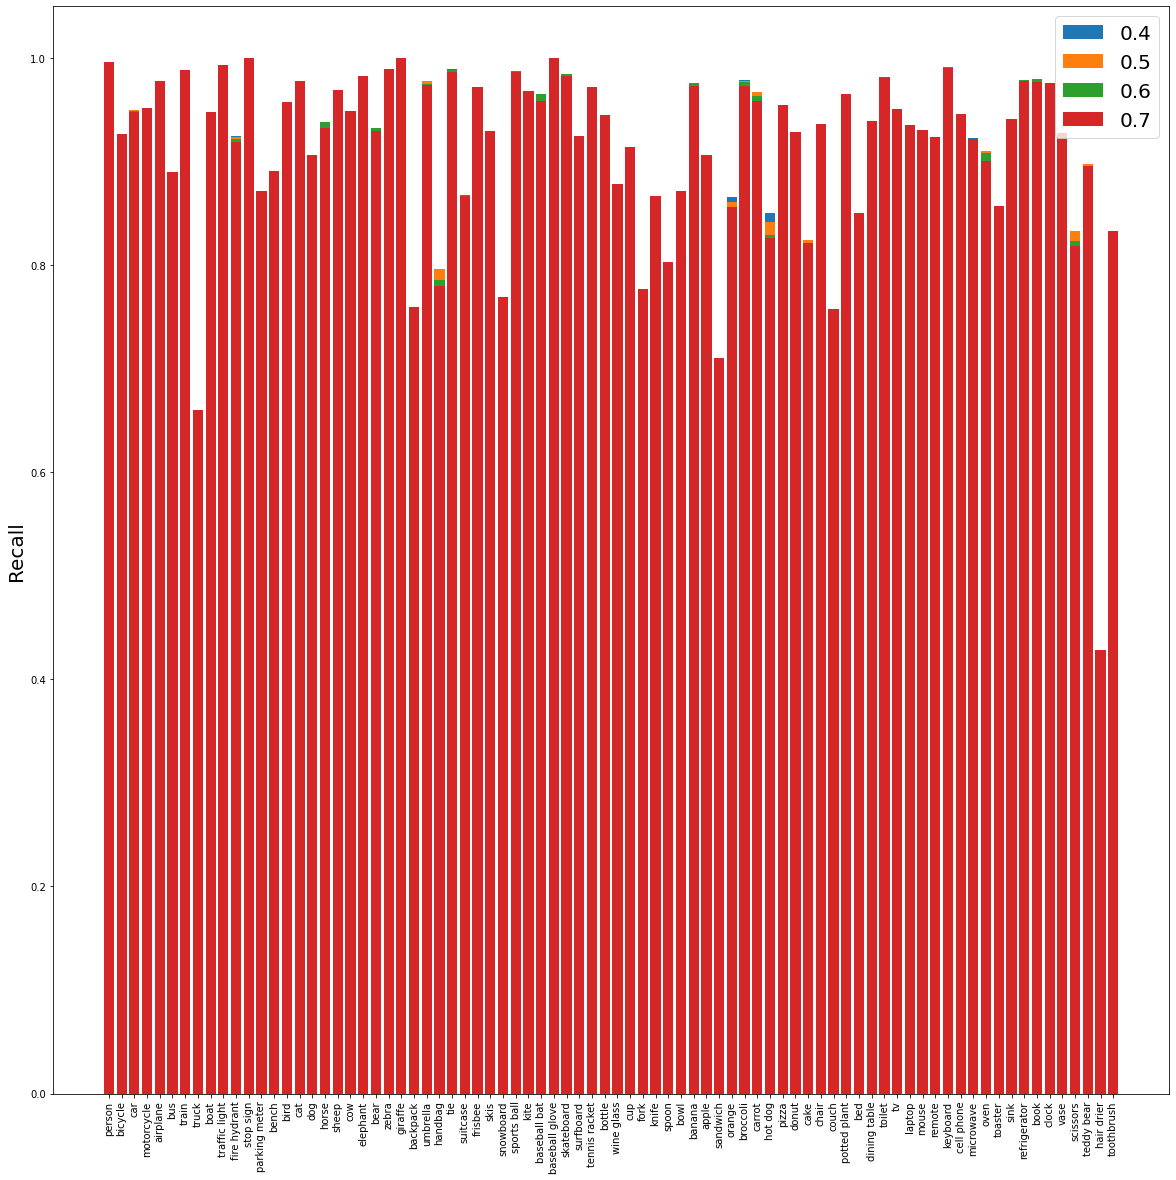

In [66]:
plt.figure(figsize=(20, 20))

plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list3[0])):
    plt.bar(class_names[1:], complete_list3[0][i])
    
plt.title("Recall Rate for Validation Set-3 with Different IOU Threshholds")
plt.ylabel("Recall", fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20);

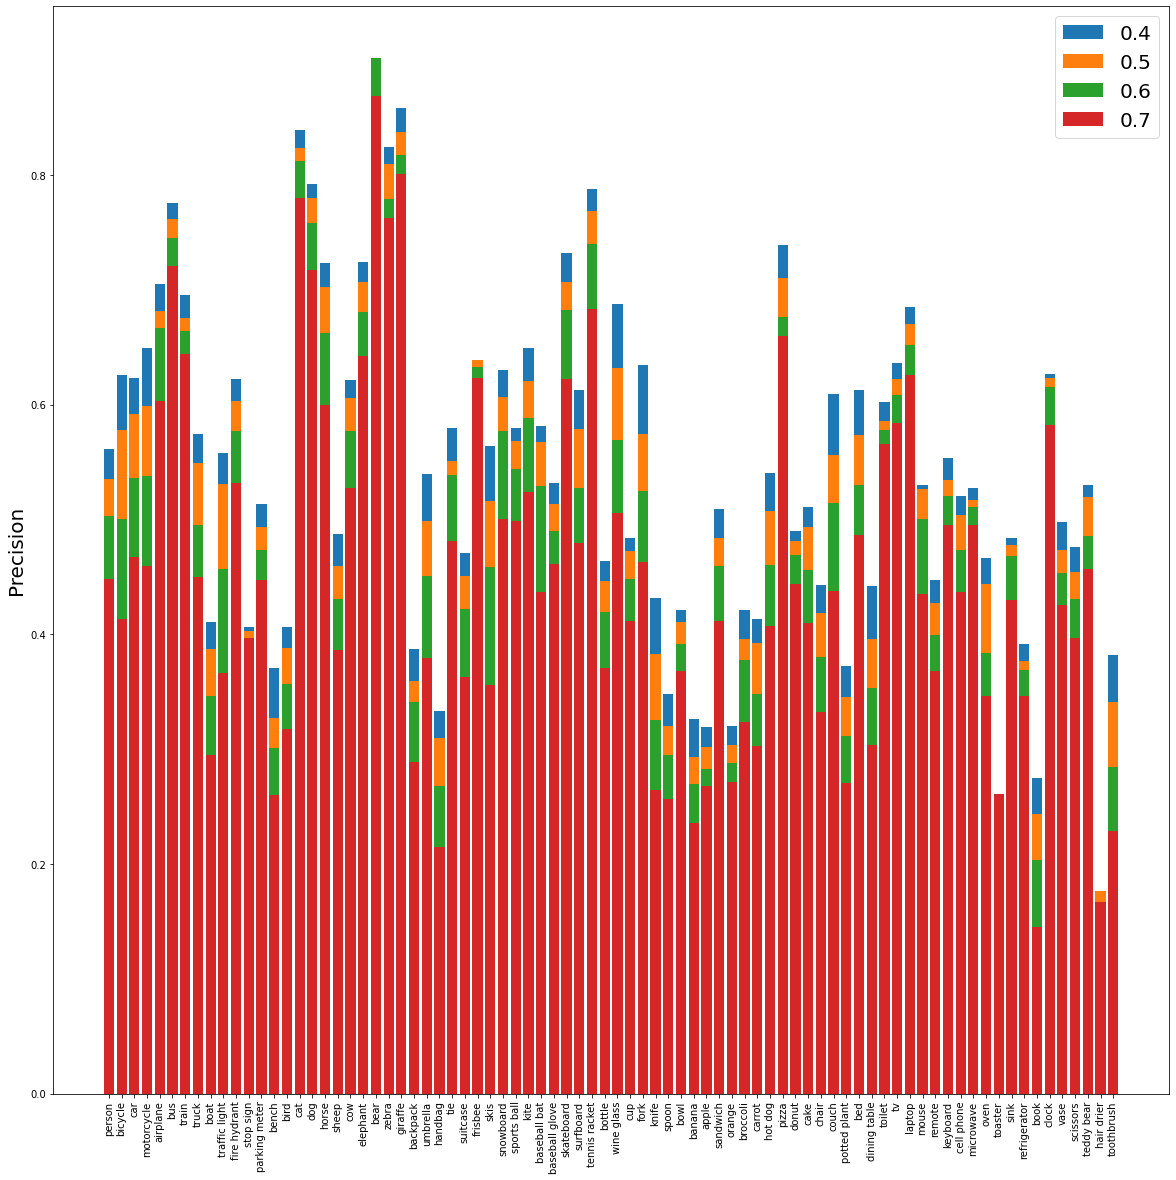

In [67]:
plt.figure(figsize=(20, 20))

plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list3[1])):
    plt.bar(class_names[1:], complete_list3[1][i])
    
plt.title("Precision for Validation Set-3 with Different IOU Threshholds")
plt.ylabel("Precision", fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20);

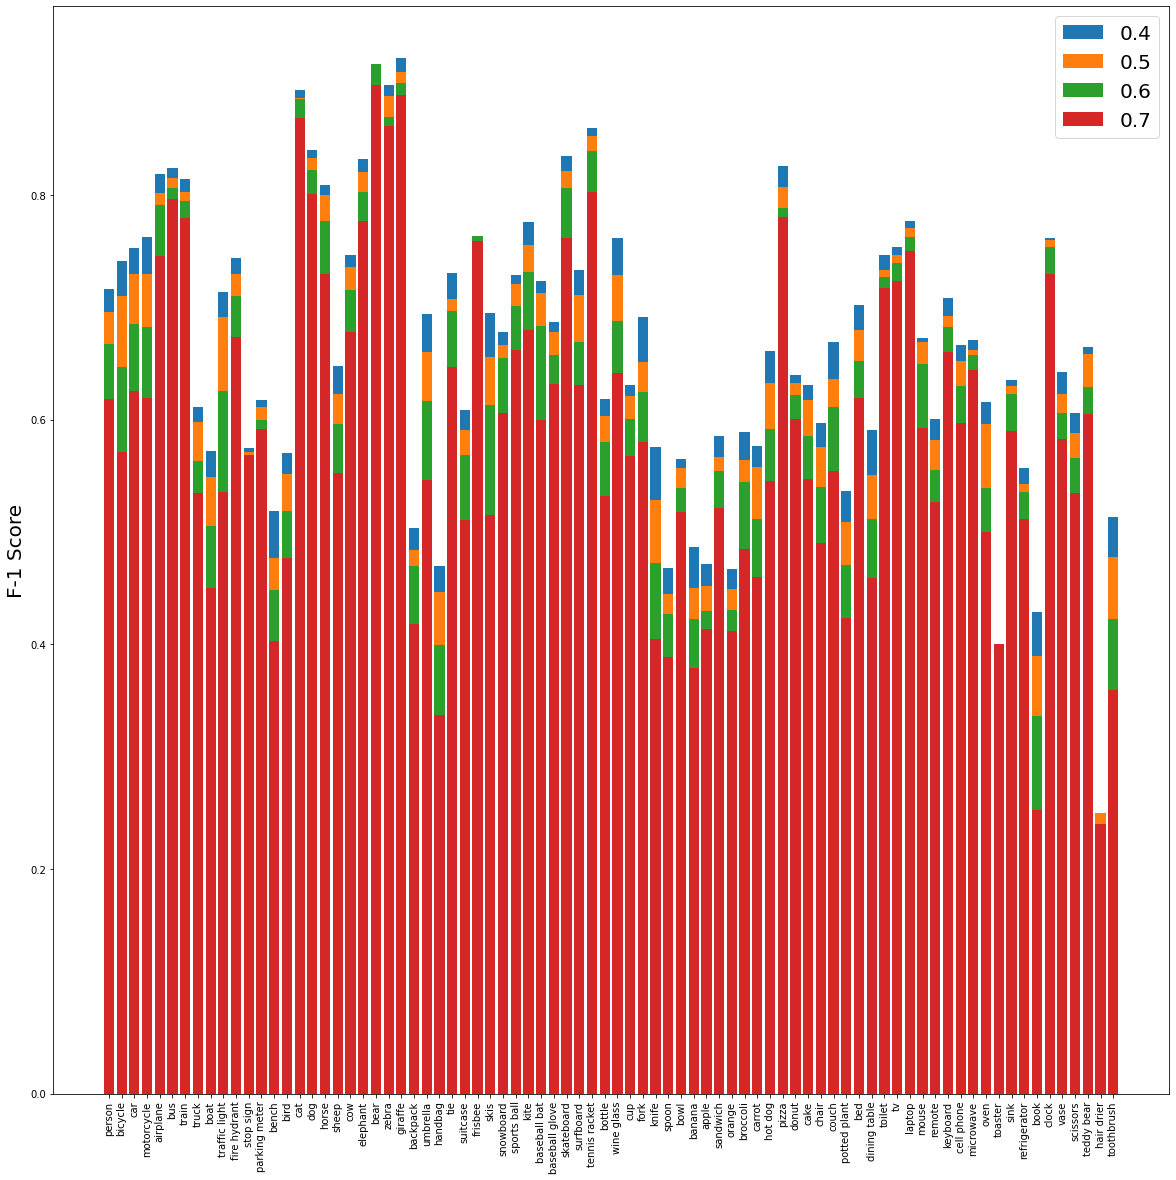

In [68]:
plt.figure(figsize=(20,20))

plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical')
for i in range(len(complete_list3[2])):
    plt.bar(class_names[1:], complete_list3[2][i])
    
plt.title("F-1 Score for Validation Set-3 with Different IOU Threshholds")
plt.ylabel("F-1 Score", fontsize=20)
plt.legend(('0.4', '0.5', "0.6", "0.7"), fontsize=20);

In [ ]:
X_axis = np.arange(len(class_names[1:]))
fig, ax = plt.subplots(1,1,figsize=(20,50))

ax.barh(X_axis - 0.3, complete_list1[1][1], 0.25, color='orange', label='val_set1')
ax.barh(X_axis, complete_list2[1][1], 0.25, color='darkblue', label='val_set2')
ax.barh(X_axis + 0.3, complete_list3[1][1], 0.25, color='red', label='val_set3')
ax.set(yticks=X_axis, yticklabels=class_names[1:], ylim=[-0.4, len(complete_list1[1][1])])

plt.legend()
plt.xlabel("Precision")
plt.ylabel("Classes")
plt.title("Precision Comparision b/w Different Validation Sets, iou_thresh=0.4")
plt.show();

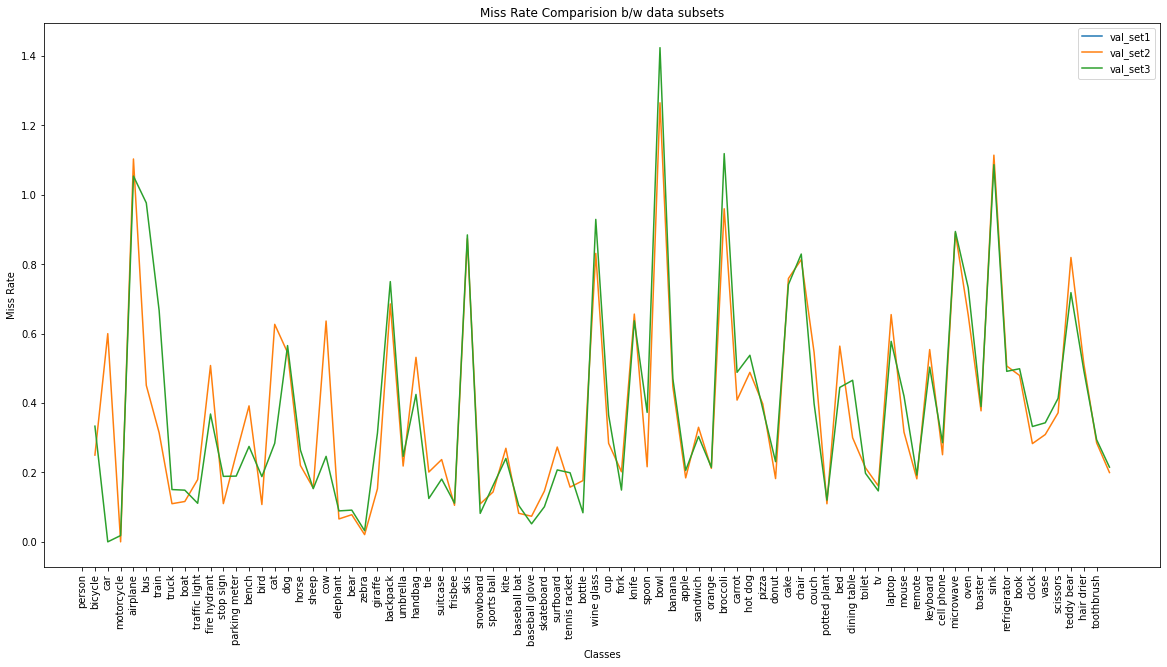

In [86]:
X_axis = np.arange(len(class_names[1:]))
l1 = real1.columns
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.plot((real1.iloc[3] / (real1.iloc[1])), label='val_set1')
ax.plot((real2[l1].iloc[3] / (real2[l1].iloc[1])), label='val_set2')
ax.plot((real3[l1].iloc[3] / (real3[l1].iloc[1])), label='val_set3')
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical');
plt.legend()
plt.xlabel("Classes")
plt.ylabel("Miss Rate")
plt.title("Miss Rate Comparision b/w Different Validation Sets, iou_thresh=0.4")
plt.show();

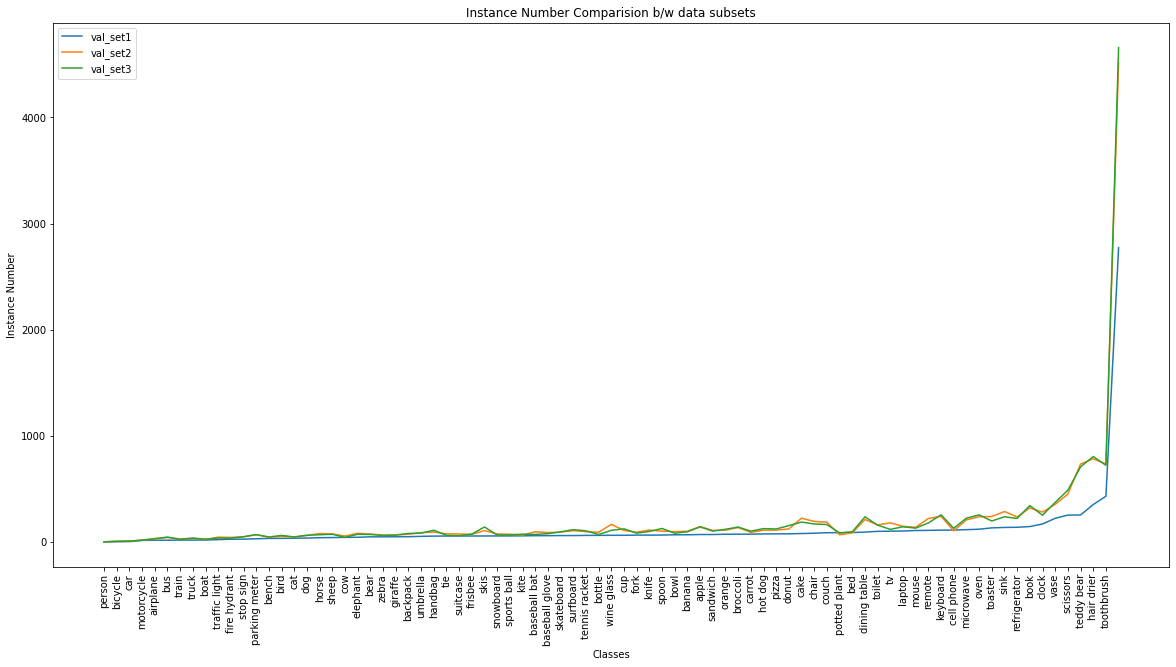

In [88]:
X_axis = np.arange(len(class_names[1:]))
l1 = real1.columns
fig, ax = plt.subplots(1, 1, figsize=(20,10))

ax.plot(real1.mean(), label='val_set1')
ax.plot(real2[l1].mean(), label='val_set2')
ax.plot(real3[l1].mean(), label='val_set3')
plt.xticks([i for i in range(80)], class_names[1:], rotation='vertical');
plt.legend()
plt.xlabel("Classes")
plt.ylabel("Instance Number")
plt.title("Instance Number Comparision b/w Different Validation Sets, iou_thresh=0.4")
plt.show();